# Image Classification: Detecting Pediatric Pneumonia

## Overview

## Business Understanding

## Data Understanding

## Data Preparation

In [1]:
#importing packages
import pandas as pd 
import splitfolders
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

import joblib
import os

from tensorflow import keras

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras.models import load_model
from sklearn.dummy import DummyClassifier
from sklearn.metrics import recall_score, classification_report, precision_score
from sklearn.model_selection import cross_val_score
from tensorflow.keras import metrics
from tensorflow.keras.wrappers import scikit_learn

from tensorflow.keras.layers import Dense
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay



import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

In [2]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [3]:
#use the splitfolders package to split our image data into train, validation, and test sets.
#this is now commented out so that we don't create a new folder each time we run the notebook


#splitfolders.ratio("Data", output="Data_Split",
#    seed=42, ratio=(.64, .16, .2), group_prefix=None, move=True)

In [2]:
# Using ImageDataGenerator to rescale all images 
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [3]:
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        'Data_Split/train',
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=4280,
        color_mode='grayscale',
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')


Found 3749 images belonging to 2 classes.


In [4]:
validation_generator = val_datagen.flow_from_directory('Data_Split/val',
                                                        target_size=(150, 150),
                                                        batch_size=978,
                                                        color_mode='grayscale',
                                                        class_mode='binary')
test_generator = test_datagen.flow_from_directory('Data_Split/test',
                                                  target_size=(150, 150),
                                                  batch_size=1173,
                                                  color_mode='grayscale',
                                                  class_mode='binary')

Found 936 images belonging to 2 classes.
Found 1107 images belonging to 2 classes.


In [5]:
#Creating the augumented data

aug_train_images = ImageDataGenerator(rotation_range=30, 
                                   width_shift_range=0.25, 
                                   height_shift_range=0.25, 
                                   shear_range=0.25, 
                                   zoom_range=0.25, 
                                   horizontal_flip=True,
                                   vertical_flip=True)

train_aug = aug_train_images.flow_from_directory('Data_Split/train',
                                                  target_size=(150, 150),
                                                  batch_size=3747,
                                                  color_mode='grayscale',
                                                  class_mode='binary')

Found 3749 images belonging to 2 classes.


In [6]:
#getting images and labels for models
train_data, train_labels = next (train_generator)
test_data, test_labels = next (test_generator)
val_data, val_labels = next (validation_generator)

In [9]:
#reshaping
train_data = train_data.reshape(train_data.shape[0], -1)
test_data = test_data.reshape(test_data.shape[0], -1)
val_data = val_data.reshape(val_data.shape[0], -1)
train_data.shape

(3749, 22500)

In [7]:
# Function to show confusion matrix 
##from sklearn
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Dummy Model
We will use a dummy model classifier as our baseline model. This model will predict the majority class. Since the majority class in our data is pneumonia, this model will predict all images are pneumonia.

In [11]:
dummy_model =  DummyClassifier(strategy='most_frequent')
dummy_model.fit(train_data, train_labels)

DummyClassifier(strategy='most_frequent')

In [12]:
y_preds_dummy = dummy_model.predict(val_data)

In [13]:
dummy_acc = dummy_model.score(val_data, val_labels)
dummy_rec = recall_score(val_labels,y_preds_dummy)
dummy_pre = precision_score(val_labels,y_preds_dummy)

print(f"Dummy Model accuracy: {dummy_acc}")
print(f"Dummy Model recall: {dummy_rec}")
print(f"Dummy Model precision: {dummy_pre}")

Dummy Model accuracy: 0.7297008547008547
Dummy Model recall: 1.0
Dummy Model precision: 0.7297008547008547


In [14]:
y_pred = (dummy_model.predict(val_data) > 0.5).astype("int32")
cm = confusion_matrix(y_true= val_labels, y_pred=y_pred) 

Confusion matrix, without normalization
[[  0 253]
 [  0 683]]


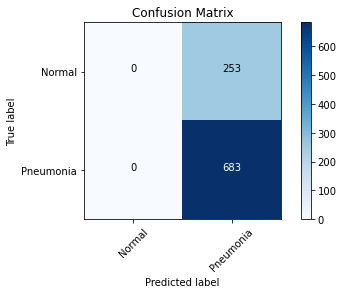

In [15]:
cm_labels = ['Normal','Pneumonia']
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix');

### Simple Model 1
Our first model will be a simple model - this will give us an idea of what improvements

In [16]:
simple_model = models.Sequential()

In [17]:
simple_model.add(layers.Dense(12, activation='relu', input_shape=(22500,)))
simple_model.add(layers.Dense(1, activation='sigmoid')) 

In [18]:
simple_model.compile(optimizer='SGD',
                       loss='binary_crossentropy',
                       metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])
simple_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                270012    
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 270,025
Trainable params: 270,025
Non-trainable params: 0
_________________________________________________________________


In [19]:
simple_model_history = simple_model.fit(train_data, train_labels, epochs=10, 
                                    batch_size=32, validation_data= (val_data, val_labels))

Epoch 1/10
118/118 [==============================] - 3s 15ms/step - loss: 0.5354 - accuracy: 0.7223 - precision: 0.7329 - recall: 0.9748 - val_loss: 0.3984 - val_accuracy: 0.8611 - val_precision: 0.8504 - val_recall: 0.9824
Epoch 2/10
118/118 [==============================] - 1s 8ms/step - loss: 0.3900 - accuracy: 0.8472 - precision: 0.8463 - recall: 0.9660 - val_loss: 0.3917 - val_accuracy: 0.8024 - val_precision: 0.7889 - val_recall: 0.9956
Epoch 3/10
118/118 [==============================] - 1s 9ms/step - loss: 0.3511 - accuracy: 0.8744 - precision: 0.8846 - recall: 0.9521 - val_loss: 0.4415 - val_accuracy: 0.8056 - val_precision: 0.9902 - val_recall: 0.7408
Epoch 4/10
118/118 [==============================] - 1s 9ms/step - loss: 0.3189 - accuracy: 0.8914 - precision: 0.9073 - recall: 0.9481 - val_loss: 0.7393 - val_accuracy: 0.2981 - val_precision: 1.0000 - val_recall: 0.0381
Epoch 5/10
118/118 [==============================] - 1s 9ms/step - loss: 0.3221 - accuracy: 0.8834 - p

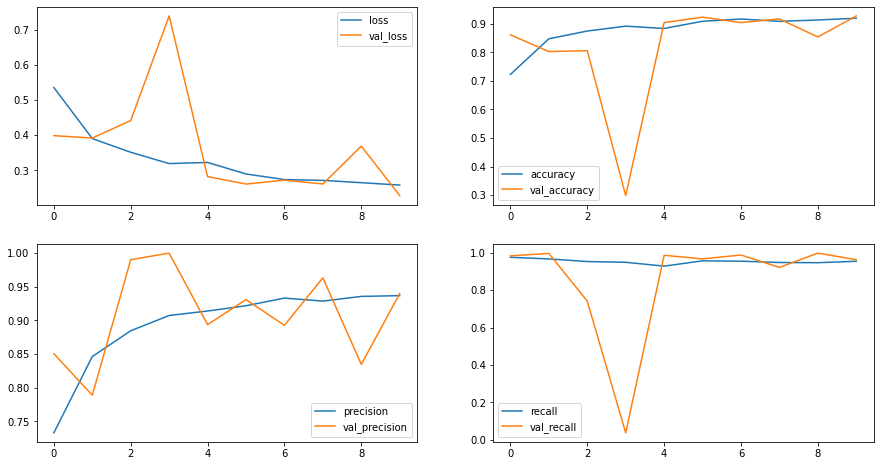

In [20]:

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

loss = simple_model_history.history['loss']
accuracy = simple_model_history.history['accuracy']
precision = simple_model_history.history['precision']
recall = simple_model_history.history['recall']

validation_loss = simple_model_history.history['val_loss']
validation_accuracy = simple_model_history.history['val_accuracy']
validation_precision = simple_model_history.history['val_precision']
validation_recall = simple_model_history.history['val_recall']

sns.lineplot(simple_model_history.epoch, simple_model_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(simple_model_history.epoch, simple_model_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')


sns.lineplot(simple_model_history.epoch, simple_model_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(simple_model_history.epoch, simple_model_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')


sns.lineplot(simple_model_history.epoch, simple_model_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(simple_model_history.epoch, simple_model_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')


sns.lineplot(simple_model_history.epoch, simple_model_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(simple_model_history.epoch, simple_model_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');



In [21]:
y_pred = (simple_model.predict(val_data) > 0.5).astype("int32")
cm = confusion_matrix(y_true= val_labels, y_pred=y_pred) 

30/30 [==============================] - 0s 3ms/step


Confusion matrix, without normalization
[[211  42]
 [ 26 657]]


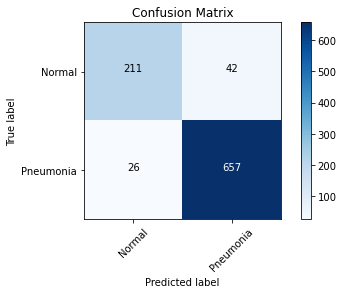

In [22]:
cm_labels = ['Normal','Pneumonia']
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix');

In [23]:
results = simple_model.evaluate(val_data, val_labels)

30/30 [==============================] - 0s 6ms/step - loss: 0.2278 - accuracy: 0.9274 - precision: 0.9399 - recall: 0.9619


In [24]:
print(f"Model loss:  {results[0]}")
print(f"Model accuracy: {results[1]}")
print(f"Model precision: {results[2]}")
print(f"Model recall: {results[3]}")

Model loss:  0.22775989770889282
Model accuracy: 0.9273504018783569
Model precision: 0.9399141669273376
Model recall: 0.9619326591491699


### CNN Model 1
Our basic CNN model

In [25]:
train_data, train_labels = next (train_generator)
test_data, test_labels = next (test_generator)
val_data, val_labels = next (validation_generator)

In [26]:
cnn1_model = models.Sequential()
cnn1_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                    input_shape=(150, 150, 1)))
cnn1_model.add(layers.MaxPooling2D((2, 2)))
cnn1_model.add(layers.Flatten())
cnn1_model.add(layers.Dense(16, activation='relu'))
cnn1_model.add(layers.Dense(1, activation='sigmoid'))

cnn1_model.compile(optimizer="adam",
                        loss='binary_crossentropy',
                        metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])

cnn1_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 147, 147, 64)      1088      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 341056)            0         
                                                                 
 dense_2 (Dense)             (None, 16)                5456912   
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 5,458,017
Trainable params: 5,458,017
Non-trainable params: 0
____________________________________________

In [27]:
cnn1_history = cnn1_model.fit(train_data,
               train_labels,
               batch_size=30,
               epochs=10,
               validation_data=(val_data, val_labels))

Epoch 1/10
125/125 [==============================] - 96s 759ms/step - loss: 0.4881 - accuracy: 0.7477 - precision: 0.7530 - recall: 0.9737 - val_loss: 0.3271 - val_accuracy: 0.8868 - val_precision: 0.8821 - val_recall: 0.9751
Epoch 2/10
125/125 [==============================] - 92s 733ms/step - loss: 0.3004 - accuracy: 0.9141 - precision: 0.9103 - recall: 0.9788 - val_loss: 0.2683 - val_accuracy: 0.9231 - val_precision: 0.9191 - val_recall: 0.9810
Epoch 3/10
125/125 [==============================] - 90s 724ms/step - loss: 0.2719 - accuracy: 0.9314 - precision: 0.9348 - recall: 0.9740 - val_loss: 0.2491 - val_accuracy: 0.9316 - val_precision: 0.9415 - val_recall: 0.9663
Epoch 4/10
125/125 [==============================] - 93s 745ms/step - loss: 0.2548 - accuracy: 0.9301 - precision: 0.9437 - recall: 0.9616 - val_loss: 0.2394 - val_accuracy: 0.9402 - val_precision: 0.9498 - val_recall: 0.9693
Epoch 5/10
125/125 [==============================] - 92s 736ms/step - loss: 0.2403 - accura

In [28]:
cnn1_model.save('models/cnn1')

INFO:tensorflow:Assets written to: models/cnn1/assets


INFO:tensorflow:Assets written to: models/cnn1/assets


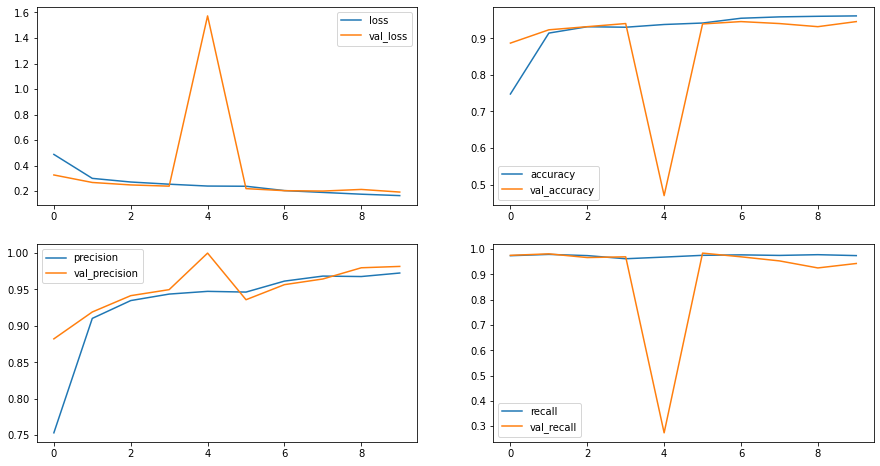

In [29]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn1_history.epoch, cnn1_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn1_history.epoch, cnn1_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn1_history.epoch, cnn1_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn1_history.epoch, cnn1_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn1_history.epoch, cnn1_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn1_history.epoch, cnn1_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn1_history.epoch, cnn1_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn1_history.epoch, cnn1_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');


In [30]:
y_pred = (cnn1_model.predict(val_data) > 0.5).astype("int32")
cm = confusion_matrix(y_true= val_labels, y_pred=y_pred)  

30/30 [==============================] - 7s 223ms/step


Confusion matrix, without normalization
[[241  12]
 [ 39 644]]


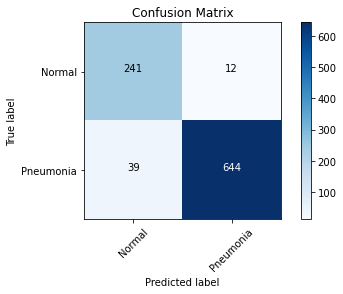

In [31]:
cm_labels = ['Normal','Pneumonia']
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix');

In [32]:
results = cnn1_model.evaluate(validation_generator)

1/1 [==============================] - 38s 38s/step - loss: 0.1932 - accuracy: 0.9455 - precision: 0.9817 - recall: 0.9429


In [33]:
print(f"Model loss:  {results[0]}")
print(f"Model accuracy: {results[1]}")
print(f"Model precision: {results[2]}")
print(f"Model recall: {results[3]}")

Model loss:  0.19320036470890045
Model accuracy: 0.9455128312110901
Model precision: 0.9817073345184326
Model recall: 0.9428989887237549


## CNN Model 2
description

In [34]:
cnn2_model = models.Sequential()
cnn2_model.add(layers.Conv2D(64, (3, 3), activation='relu', 
                            input_shape=(150,150,1)))
cnn2_model.add(layers.MaxPooling2D((2,2)))
cnn2_model.add(layers.Conv2D(32, (3,3), activation='relu'))       
cnn2_model.add(layers.MaxPooling2D((2,2)))
cnn2_model.add(layers.Flatten())
cnn2_model.add(Dense(16, activation='relu'))
cnn2_model.add(Dense(1, activation='sigmoid')) 

cnn2_model.compile(optimizer="adam",
                        loss='binary_crossentropy',
                        metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])

cnn2_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 148, 148, 64)      640       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 72, 72, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 41472)             0         
                                                                 
 dense_4 (Dense)             (None, 16)               

In [35]:
cnn2_history = cnn2_model.fit(train_data,
               train_labels,
               batch_size=50,
               epochs=10,
               validation_data=(val_data, val_labels))

Epoch 1/10
75/75 [==============================] - 166s 2s/step - loss: 0.4801 - accuracy: 0.7437 - precision: 0.7443 - recall: 0.9883 - val_loss: 0.3349 - val_accuracy: 0.9017 - val_precision: 0.9404 - val_recall: 0.9239
Epoch 2/10
75/75 [==============================] - 168s 2s/step - loss: 0.2844 - accuracy: 0.9136 - precision: 0.9116 - recall: 0.9762 - val_loss: 0.2697 - val_accuracy: 0.9060 - val_precision: 0.8899 - val_recall: 0.9941
Epoch 3/10
75/75 [==============================] - 158s 2s/step - loss: 0.2619 - accuracy: 0.9314 - precision: 0.9317 - recall: 0.9777 - val_loss: 0.2513 - val_accuracy: 0.9476 - val_precision: 0.9529 - val_recall: 0.9766
Epoch 4/10
75/75 [==============================] - 127s 2s/step - loss: 0.2454 - accuracy: 0.9370 - precision: 0.9392 - recall: 0.9770 - val_loss: 0.2409 - val_accuracy: 0.9402 - val_precision: 0.9409 - val_recall: 0.9795
Epoch 5/10
75/75 [==============================] - 117s 2s/step - loss: 0.2393 - accuracy: 0.9427 - precisi

In [36]:
cnn2_model.save('models/cnn2')

INFO:tensorflow:Assets written to: models/cnn2/assets


INFO:tensorflow:Assets written to: models/cnn2/assets


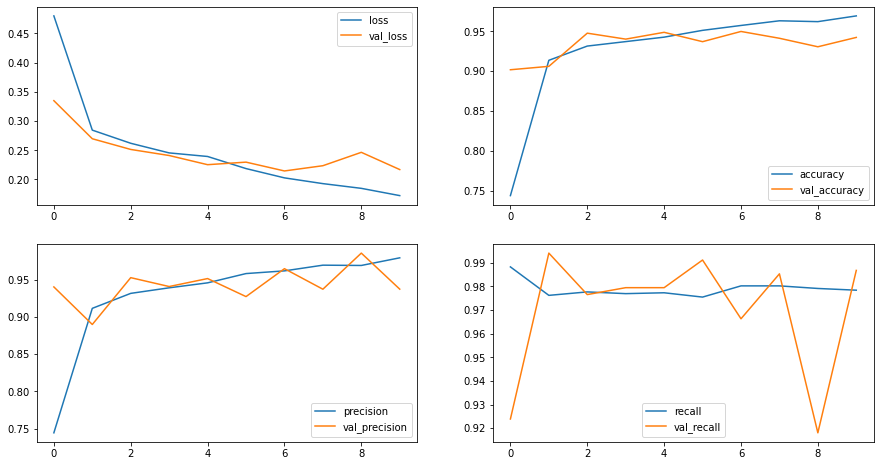

In [37]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn2_history.epoch, cnn2_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn2_history.epoch, cnn2_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn2_history.epoch, cnn2_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn2_history.epoch, cnn2_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn2_history.epoch, cnn2_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn2_history.epoch, cnn2_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn2_history.epoch, cnn2_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn2_history.epoch, cnn2_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');

In [38]:
y_pred = (cnn2_model.predict(val_data) > 0.5).astype("int32")
cm = confusion_matrix(y_true= val_labels, y_pred=y_pred)  

30/30 [==============================] - 10s 320ms/step


Confusion matrix, without normalization
[[208  45]
 [  9 674]]


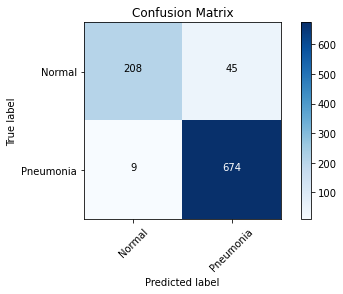

In [39]:
cm_labels = ['Normal','Pneumonia']
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix');

In [40]:
results = cnn2_model.evaluate(validation_generator)

1/1 [==============================] - 34s 34s/step - loss: 0.2169 - accuracy: 0.9423 - precision: 0.9374 - recall: 0.9868


In [41]:
print(f"Model loss:  {results[0]}")
print(f"Model accuracy: {results[1]}")
print(f"Model precision: {results[2]}")
print(f"Model recall: {results[3]}")

Model loss:  0.21687419712543488
Model accuracy: 0.942307710647583
Model precision: 0.9374130964279175
Model recall: 0.9868228435516357


### CNN Model 3

In [42]:
cnn3_model = models.Sequential()
cnn3_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                      input_shape=(150, 150, 1)))
cnn3_model.add(layers.MaxPooling2D((2, 2)))
cnn3_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn3_model.add(layers.MaxPooling2D((2,2)))
cnn3_model.add(layers.Flatten())
cnn3_model.add(layers.Dense(16, activation='relu'))
cnn3_model.add(layers.Dense(1, activation='sigmoid'))

cnn3_model.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])

cnn3_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 147, 147, 64)      1088      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 71, 71, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 35, 35, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 39200)             0         
                                                                 
 dense_6 (Dense)             (None, 16)               

In [43]:
cnn3_history = cnn3_model.fit(train_data,
               train_labels,
               batch_size=32,
               epochs=10,
               validation_data=(val_data, val_labels))

Epoch 1/10
118/118 [==============================] - 120s 1s/step - loss: 0.3296 - accuracy: 0.8522 - precision: 0.8584 - recall: 0.9550 - val_loss: 0.2242 - val_accuracy: 0.8942 - val_precision: 0.8842 - val_recall: 0.9839
Epoch 2/10
118/118 [==============================] - 119s 1s/step - loss: 0.1945 - accuracy: 0.9208 - precision: 0.9366 - recall: 0.9561 - val_loss: 0.1620 - val_accuracy: 0.9434 - val_precision: 0.9758 - val_recall: 0.9458
Epoch 3/10
118/118 [==============================] - 123s 1s/step - loss: 0.1588 - accuracy: 0.9408 - precision: 0.9518 - recall: 0.9678 - val_loss: 0.1363 - val_accuracy: 0.9444 - val_precision: 0.9759 - val_recall: 0.9473
Epoch 4/10
118/118 [==============================] - 138s 1s/step - loss: 0.1720 - accuracy: 0.9360 - precision: 0.9496 - recall: 0.9635 - val_loss: 0.1380 - val_accuracy: 0.9412 - val_precision: 0.9398 - val_recall: 0.9824
Epoch 5/10
118/118 [==============================] - 119s 1s/step - loss: 0.1286 - accuracy: 0.9531

In [44]:
cnn3_model.save('models/cnn3')

INFO:tensorflow:Assets written to: models/cnn3/assets


INFO:tensorflow:Assets written to: models/cnn3/assets


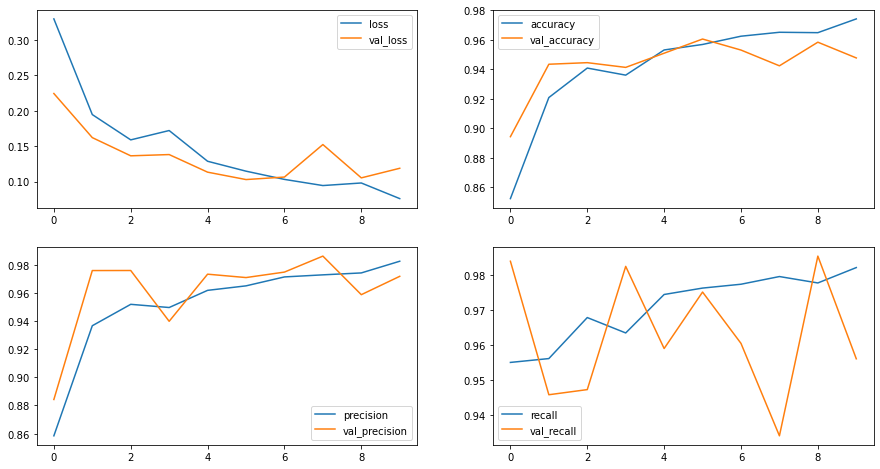

In [45]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn3_history.epoch, cnn3_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn3_history.epoch, cnn3_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn3_history.epoch, cnn3_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn3_history.epoch, cnn3_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn3_history.epoch, cnn3_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn3_history.epoch, cnn3_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn3_history.epoch, cnn3_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn3_history.epoch, cnn3_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');

In [46]:
y_pred = (cnn3_model.predict(val_data) > 0.5).astype("int32")
cm = confusion_matrix(y_true= val_labels, y_pred=y_pred)  

30/30 [==============================] - 8s 271ms/step


Confusion matrix, without normalization
[[234  19]
 [ 30 653]]


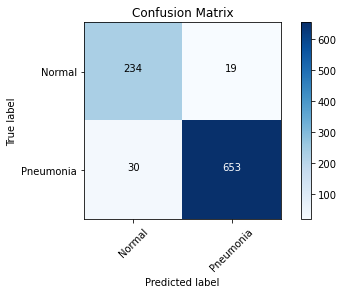

In [47]:
cm_labels = ['Normal','Pneumonia']
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix');

In [48]:
results = cnn3_model.evaluate(validation_generator)

1/1 [==============================] - 30s 30s/step - loss: 0.1187 - accuracy: 0.9476 - precision: 0.9717 - recall: 0.9561


In [49]:
print(f"Model loss:  {results[0]}")
print(f"Model accuracy: {results[1]}")
print(f"Model precision: {results[2]}")
print(f"Model recall: {results[3]}")

Model loss:  0.1186876893043518
Model accuracy: 0.9476495981216431
Model precision: 0.9717261791229248
Model recall: 0.9560761451721191


### CNN Model 4

In [50]:
cnn4_model = models.Sequential()
cnn4_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.05)))
cnn4_model.add(layers.MaxPooling2D((2, 2)))
cnn4_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.05)))
cnn4_model.add(layers.MaxPooling2D((2,2)))
cnn4_model.add(layers.Flatten())
cnn4_model.add(layers.Dense(16, activation='relu'))
cnn4_model.add(layers.Dense(1, activation='sigmoid'))

cnn4_model.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])
cnn4_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 147, 147, 64)      1088      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 71, 71, 32)        18464     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 35, 35, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 39200)             0         
                                                                 
 dense_8 (Dense)             (None, 16)               

In [51]:
cnn4_history = cnn4_model.fit(train_data,
              train_labels,
              batch_size=32,
              epochs=10,
              validation_data=(val_data, val_labels))

Epoch 1/10
118/118 [==============================] - 121s 1s/step - loss: 1.0784 - accuracy: 0.7533 - precision: 0.7519 - recall: 0.9879 - val_loss: 0.4460 - val_accuracy: 0.8718 - val_precision: 0.8577 - val_recall: 0.9883
Epoch 2/10
118/118 [==============================] - 119s 1s/step - loss: 0.4020 - accuracy: 0.8672 - precision: 0.8552 - recall: 0.9846 - val_loss: 0.3510 - val_accuracy: 0.9135 - val_precision: 0.9375 - val_recall: 0.9444
Epoch 3/10
118/118 [==============================] - 118s 1s/step - loss: 0.3464 - accuracy: 0.9024 - precision: 0.9042 - recall: 0.9689 - val_loss: 0.3346 - val_accuracy: 0.9167 - val_precision: 0.9353 - val_recall: 0.9517
Epoch 4/10
118/118 [==============================] - 144s 1s/step - loss: 0.3116 - accuracy: 0.9136 - precision: 0.9147 - recall: 0.9722 - val_loss: 0.3326 - val_accuracy: 0.8793 - val_precision: 0.8589 - val_recall: 0.9985
Epoch 5/10
118/118 [==============================] - 155s 1s/step - loss: 0.2945 - accuracy: 0.9157

In [52]:
cnn4_model.save('models/cnn4')

INFO:tensorflow:Assets written to: models/cnn4/assets


INFO:tensorflow:Assets written to: models/cnn4/assets


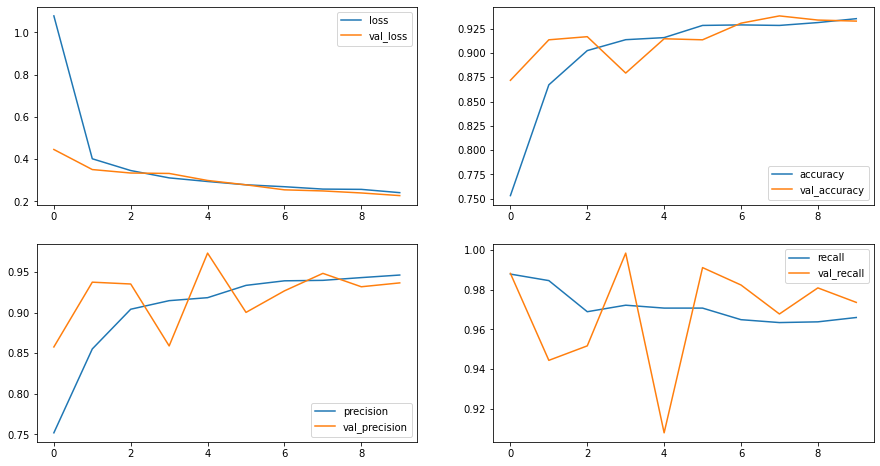

In [53]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn4_history.epoch, cnn4_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn4_history.epoch, cnn4_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn4_history.epoch, cnn4_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn4_history.epoch, cnn4_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn4_history.epoch, cnn4_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn4_history.epoch, cnn4_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn4_history.epoch, cnn4_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn4_history.epoch, cnn4_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');

In [54]:
y_pred = (cnn4_model.predict(val_data) > 0.5).astype("int32")
cm = confusion_matrix(y_true= val_labels, y_pred=y_pred)  

30/30 [==============================] - 9s 311ms/step


Confusion matrix, without normalization
[[208  45]
 [ 18 665]]


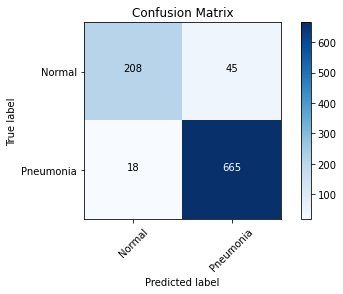

In [55]:
cm_labels = ['Normal','Pneumonia']
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix');

In [56]:
results = cnn4_model.evaluate(validation_generator)

1/1 [==============================] - 30s 30s/step - loss: 0.2277 - accuracy: 0.9327 - precision: 0.9366 - recall: 0.9736


In [57]:
print(f"Model loss:  {results[0]}")
print(f"Model accuracy: {results[1]}")
print(f"Model precision: {results[2]}")
print(f"Model recall: {results[3]}")

Model loss:  0.2277037799358368
Model accuracy: 0.932692289352417
Model precision: 0.9366196990013123
Model recall: 0.9736456871032715


### CNN Model 5

In [56]:
cnn5_model = models.Sequential()
cnn5_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.05)))
cnn5_model.add(layers.MaxPooling2D((2, 2)))
cnn5_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.05)))
cnn5_model.add(layers.MaxPooling2D((2,2)))
cnn5_model.add(layers.Flatten())
cnn5_model.add(layers.Dense(16, activation='relu'))
cnn5_model.add(layers.Dropout(0.5))
cnn5_model.add(layers.Dense(1, activation='sigmoid'))

cnn5_model.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])

cnn5_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 147, 147, 64)      1088      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 71, 71, 32)        18464     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 39200)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                627216    
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)               

In [57]:
cnn5_history = cnn5_model.fit(train_data,
               train_labels,
               batch_size=32,
               epochs=10,
               validation_data=(val_data, val_labels))

Epoch 1/10
118/118 [==============================] - 27s 233ms/step - loss: 1.0317 - accuracy: 0.7282 - precision: 0.7302 - recall: 0.9952 - val_loss: 0.4166 - val_accuracy: 0.7297 - val_precision: 0.7297 - val_recall: 1.0000
Epoch 2/10
118/118 [==============================] - 30s 252ms/step - loss: 0.4413 - accuracy: 0.7887 - precision: 0.7956 - recall: 0.9561 - val_loss: 0.3442 - val_accuracy: 0.8996 - val_precision: 0.9029 - val_recall: 0.9663
Epoch 3/10
118/118 [==============================] - 29s 247ms/step - loss: 0.3975 - accuracy: 0.8493 - precision: 0.9089 - recall: 0.8819 - val_loss: 0.3169 - val_accuracy: 0.9252 - val_precision: 0.9311 - val_recall: 0.9693
Epoch 4/10
118/118 [==============================] - 29s 244ms/step - loss: 0.3670 - accuracy: 0.8600 - precision: 0.9151 - recall: 0.8907 - val_loss: 0.3091 - val_accuracy: 0.8985 - val_precision: 0.9027 - val_recall: 0.9649
Epoch 5/10
118/118 [==============================] - 29s 242ms/step - loss: 0.3497 - accura

In [14]:
cnn5_model.save('test/cnn5.h5')

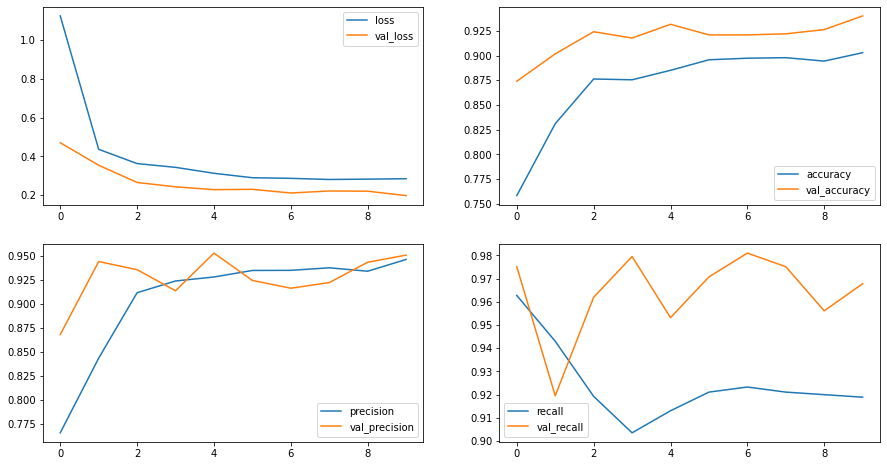

In [61]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn5_history.epoch, cnn5_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn5_history.epoch, cnn5_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn5_history.epoch, cnn5_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn5_history.epoch, cnn5_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn5_history.epoch, cnn5_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn5_history.epoch, cnn5_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn5_history.epoch, cnn5_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn5_history.epoch, cnn5_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');

In [12]:
y_pred = (cnn5_model.predict(val_data) > 0.25).astype("int32")
cm = confusion_matrix(y_true= val_labels, y_pred=y_pred)  

Confusion matrix, without normalization
[[167  86]
 [  3 680]]


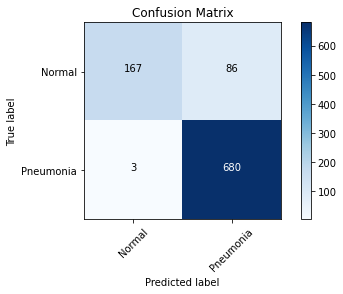

In [13]:
cm_labels = ['Normal','Pneumonia']
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix');

In [15]:
results = cnn5_model.evaluate(validation_generator)

1/1 [==============================] - 0s 0s/step - loss: 0.1879 - accuracy: 0.9338 - precision: 0.9493 - recall: 0.9605


In [16]:
print(f"Model loss:  {results[0]}")
print(f"Model accuracy: {results[1]}")
print(f"Model precision: {results[2]}")
print(f"Model recall: {results[3]}")

Model loss:  0.1879357099533081
Model accuracy: 0.9337607026100159
Model precision: 0.9493487477302551
Model recall: 0.9604685306549072


In [55]:
cnn5_loaded = load_model('models/cnn5')

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [44]:
cnn5_loaded.evaluate(validation_generator)

1/1 [==============================] - 0s 938us/step - loss: 0.1879 - accuracy: 0.9338 - precision: 0.9493 - recall: 0.9605


[0.1879357099533081,
 0.9337607026100159,
 0.9493487477302551,
 0.9604685306549072]

In [48]:
type(cnn5_loaded)

tensorflow.python.keras.engine.sequential.Sequential

In [47]:
cnn5_loaded.predict()

TypeError: 'History' object is not subscriptable

### CNN Model 6

In [17]:
cnn6_model = models.Sequential()
cnn6_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.05)))
cnn6_model.add(layers.MaxPooling2D((2, 2)))
cnn6_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.05)))
cnn6_model.add(layers.MaxPooling2D((2,2)))
cnn6_model.add(layers.Flatten())
cnn6_model.add(layers.Dense(16, activation='relu'))
cnn6_model.add(layers.Dropout(0.3))
cnn6_model.add(layers.Dense(1, activation='sigmoid'))

cnn6_model.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])

cnn6_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 147, 147, 64)      1088      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 71, 32)        18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 39200)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                627216    
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)               

In [18]:
cnn6_history = cnn6_model.fit(train_data,
               train_labels,
               batch_size=32,
               epochs=25,
               validation_data=(val_data, val_labels))

Epoch 1/25
118/118 [==============================] - 26s 224ms/step - loss: 1.1210 - accuracy: 0.7477 - precision: 0.7485 - recall: 0.9854 - val_loss: 0.4627 - val_accuracy: 0.8600 - val_precision: 0.8450 - val_recall: 0.9898
Epoch 2/25
118/118 [==============================] - 27s 229ms/step - loss: 0.4278 - accuracy: 0.8760 - precision: 0.8774 - recall: 0.9649 - val_loss: 0.3586 - val_accuracy: 0.8857 - val_precision: 0.8702 - val_recall: 0.9912
Epoch 3/25
118/118 [==============================] - 29s 242ms/step - loss: 0.3603 - accuracy: 0.8944 - precision: 0.9105 - recall: 0.9485 - val_loss: 0.3235 - val_accuracy: 0.9060 - val_precision: 0.8993 - val_recall: 0.9810
Epoch 4/25
118/118 [==============================] - 28s 238ms/step - loss: 0.3302 - accuracy: 0.9008 - precision: 0.9177 - recall: 0.9492 - val_loss: 0.2845 - val_accuracy: 0.9338 - val_precision: 0.9493 - val_recall: 0.9605
Epoch 5/25
118/118 [==============================] - 28s 237ms/step - loss: 0.3157 - accura

In [19]:
cnn6_model.save('test/cnn6.h5')

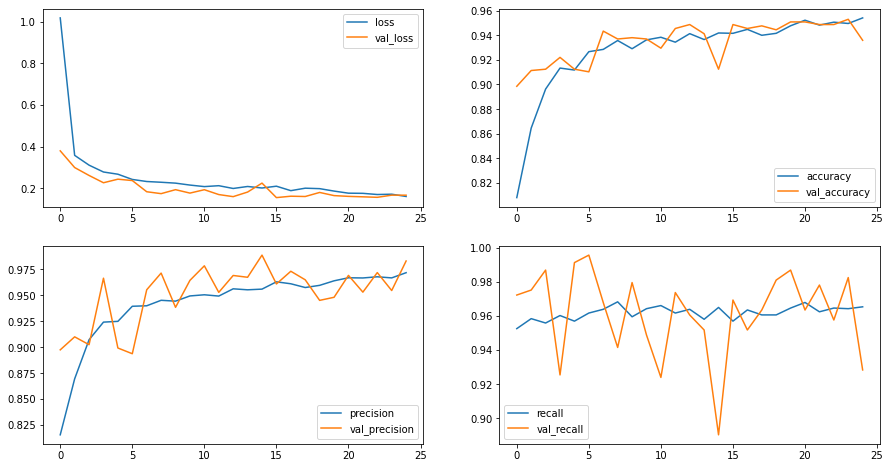

In [69]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn6_history.epoch, cnn6_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn6_history.epoch, cnn6_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn6_history.epoch, cnn6_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn6_history.epoch, cnn6_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn6_history.epoch, cnn6_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn6_history.epoch, cnn6_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn6_history.epoch, cnn6_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn6_history.epoch, cnn6_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');

In [22]:
y_pred = (cnn6_model.predict(val_data) > 0.25).astype("int32")
cm = confusion_matrix(y_true= val_labels, y_pred=y_pred)  

Confusion matrix, without normalization
[[216  37]
 [ 12 671]]


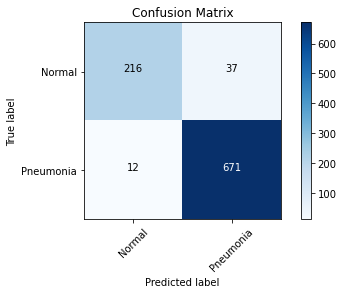

In [23]:
cm_labels = ['Normal','Pneumonia']
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix');

In [24]:
results = cnn6_model.evaluate(validation_generator)

1/1 [==============================] - 0s 0s/step - loss: 0.1899 - accuracy: 0.9391 - precision: 0.9658 - recall: 0.9502


In [25]:
print(f"Model loss:  {results[0]}")
print(f"Model accuracy: {results[1]}")
print(f"Model precision: {results[2]}")
print(f"Model recall: {results[3]}")

Model loss:  0.189903125166893
Model accuracy: 0.9391025900840759
Model precision: 0.9657738208770752
Model recall: 0.9502196311950684


### CNN Model 7

In [26]:
cnn7_model = models.Sequential()
cnn7_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.025)))
cnn7_model.add(layers.MaxPooling2D((2, 2)))
cnn7_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
cnn7_model.add(layers.MaxPooling2D((2,2)))
cnn7_model.add(layers.Flatten())
cnn7_model.add(layers.Dense(16, activation='relu'))
cnn7_model.add(layers.Dropout(0.3))
cnn7_model.add(layers.Dense(1, activation='sigmoid'))

cnn7_model.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])
cnn7_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 147, 147, 64)      1088      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 71, 71, 32)        18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 39200)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                627216    
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)               

In [27]:
cnn7_history = cnn7_model.fit(train_data,
               train_labels,
               batch_size=32,
               epochs=25,
               validation_data=(val_data, val_labels))

Epoch 1/25
118/118 [==============================] - 26s 220ms/step - loss: 0.8369 - accuracy: 0.7821 - precision: 0.7744 - recall: 0.9898 - val_loss: 0.4633 - val_accuracy: 0.8451 - val_precision: 0.8273 - val_recall: 0.9956
Epoch 2/25
118/118 [==============================] - 26s 224ms/step - loss: 0.4174 - accuracy: 0.8864 - precision: 0.8779 - recall: 0.9806 - val_loss: 0.3677 - val_accuracy: 0.8739 - val_precision: 0.8571 - val_recall: 0.9927
Epoch 3/25
118/118 [==============================] - 29s 244ms/step - loss: 0.3557 - accuracy: 0.9138 - precision: 0.9142 - recall: 0.9733 - val_loss: 0.3142 - val_accuracy: 0.9220 - val_precision: 0.9155 - val_recall: 0.9839
Epoch 4/25
118/118 [==============================] - 29s 242ms/step - loss: 0.3210 - accuracy: 0.9256 - precision: 0.9297 - recall: 0.9715 - val_loss: 0.3415 - val_accuracy: 0.8771 - val_precision: 0.8577 - val_recall: 0.9971
Epoch 5/25
118/118 [==============================] - 29s 242ms/step - loss: 0.3034 - accura

In [28]:
cnn7_model.save('test/cnn7.h5')

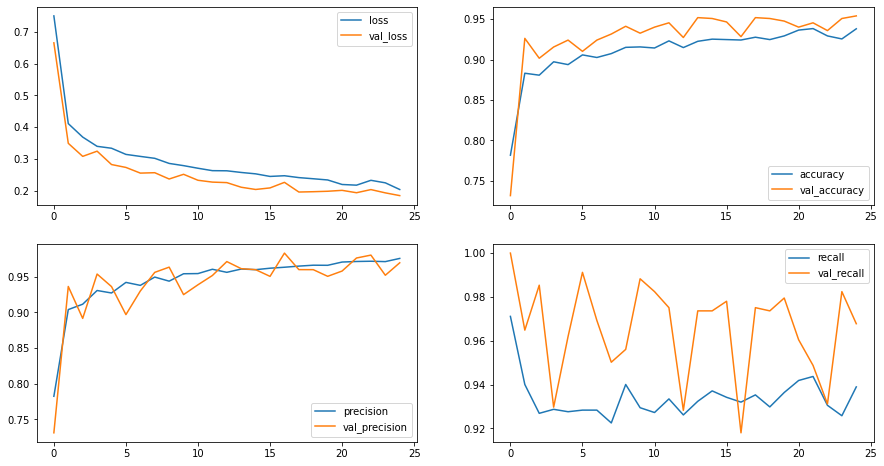

In [77]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn7_history.epoch, cnn7_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn7_history.epoch, cnn7_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn7_history.epoch, cnn7_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn7_history.epoch, cnn7_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn7_history.epoch, cnn7_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn7_history.epoch, cnn7_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn7_history.epoch, cnn7_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn7_history.epoch, cnn7_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');

In [31]:
y_pred = (cnn7_model.predict(val_data) > 0.25).astype("int32")
cm = confusion_matrix(y_true= val_labels, y_pred=y_pred)  

Confusion matrix, without normalization
[[205  48]
 [  6 677]]


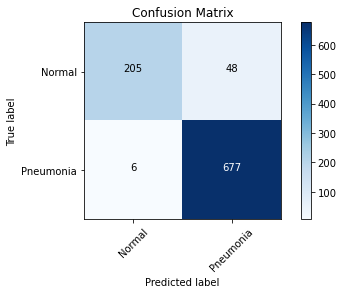

In [32]:
cm_labels = ['Normal','Pneumonia']
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix');

In [33]:
results = cnn7_model.evaluate(validation_generator)

1/1 [==============================] - 0s 0s/step - loss: 0.1711 - accuracy: 0.9530 - precision: 0.9558 - recall: 0.9810


In [34]:
print(f"Model loss:  {results[0]}")
print(f"Model accuracy: {results[1]}")
print(f"Model precision: {results[2]}")
print(f"Model recall: {results[3]}")

Model loss:  0.17112702131271362
Model accuracy: 0.9529914259910583
Model precision: 0.9557774662971497
Model recall: 0.980966329574585


### CNN Model 8

In [35]:

cnn8_model = models.Sequential()
cnn8_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.025)))
cnn8_model.add(layers.MaxPooling2D((3, 3)))
cnn8_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
cnn8_model.add(layers.MaxPooling2D((3, 3)))
cnn8_model.add(layers.Flatten())
cnn8_model.add(layers.Dense(16, activation='relu'))
cnn8_model.add(layers.Dropout(0.3))
cnn8_model.add(layers.Dense(1, activation='sigmoid'))

cnn8_model.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])

cnn8_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 147, 147, 64)      1088      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 47, 47, 32)        18464     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 7200)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                115216    
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)               

In [36]:
cnn8_history = cnn8_model.fit(train_data,
               train_labels,
               batch_size=32,
               epochs=25,
               validation_data=(val_data, val_labels))

Epoch 1/25
118/118 [==============================] - 18s 156ms/step - loss: 0.7703 - accuracy: 0.7533 - precision: 0.7506 - recall: 0.9912 - val_loss: 0.4238 - val_accuracy: 0.8291 - val_precision: 0.8147 - val_recall: 0.9912
Epoch 2/25
118/118 [==============================] - 18s 155ms/step - loss: 0.3927 - accuracy: 0.8850 - precision: 0.8736 - recall: 0.9850 - val_loss: 0.3423 - val_accuracy: 0.9135 - val_precision: 0.9068 - val_recall: 0.9824
Epoch 3/25
118/118 [==============================] - 20s 166ms/step - loss: 0.3521 - accuracy: 0.8970 - precision: 0.8967 - recall: 0.9708 - val_loss: 0.3144 - val_accuracy: 0.9006 - val_precision: 0.8892 - val_recall: 0.9868
Epoch 4/25
118/118 [==============================] - 20s 171ms/step - loss: 0.3211 - accuracy: 0.9162 - precision: 0.9136 - recall: 0.9777 - val_loss: 0.3571 - val_accuracy: 0.8141 - val_precision: 0.7970 - val_recall: 1.0000
Epoch 5/25
118/118 [==============================] - 20s 170ms/step - loss: 0.3076 - accura

In [37]:
cnn8_model.save('test/cnn8.h5')

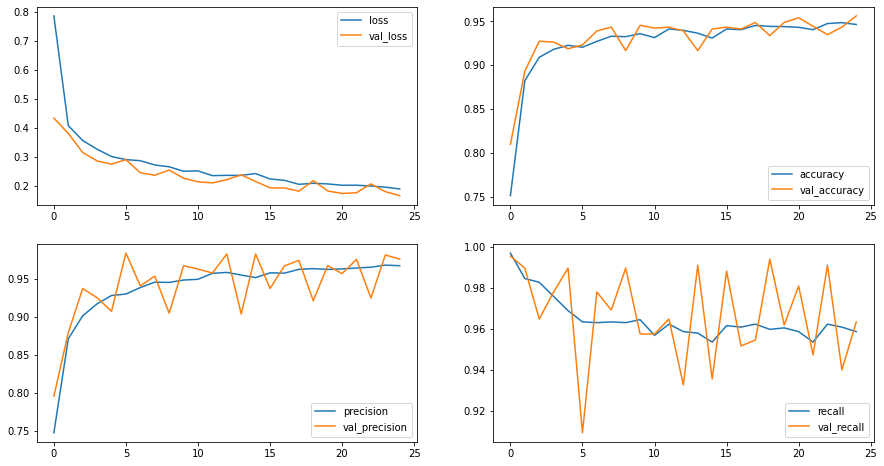

In [85]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn8_history.epoch, cnn8_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn8_history.epoch, cnn8_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn8_history.epoch, cnn8_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn8_history.epoch, cnn8_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn8_history.epoch, cnn8_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn8_history.epoch, cnn8_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn8_history.epoch, cnn8_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn8_history.epoch, cnn8_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');

In [38]:
y_pred = (cnn8_model.predict(val_data) > 0.5).astype("int32")
cm = confusion_matrix(y_true= val_labels, y_pred=y_pred)  

Confusion matrix, without normalization
[[229  24]
 [ 21 662]]


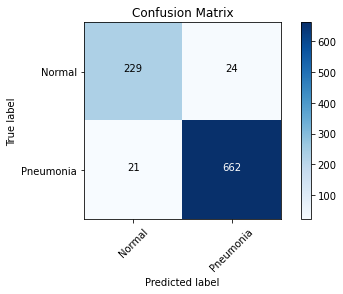

In [39]:
cm_labels = ['Normal','Pneumonia']
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix');

In [40]:
results = cnn8_model.evaluate(validation_generator)

1/1 [==============================] - 0s 0s/step - loss: 0.1645 - accuracy: 0.9519 - precision: 0.9650 - recall: 0.9693


In [41]:
print(f"Model loss:  {results[0]}")
print(f"Model accuracy: {results[1]}")
print(f"Model precision: {results[2]}")
print(f"Model recall: {results[3]}")

Model loss:  0.16450251638889313
Model accuracy: 0.9519230723381042
Model precision: 0.9650145769119263
Model recall: 0.9692533016204834


### CNN Model 9

In [90]:
cnn9_model = models.Sequential()
cnn9_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.025)))
cnn9_model.add(layers.MaxPooling2D((3, 3)))
cnn9_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
cnn9_model.add(layers.MaxPooling2D((3, 3)))
cnn9_model.add(layers.Conv2D(16, (2, 2), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
cnn9_model.add(layers.MaxPooling2D((3, 3)))
cnn9_model.add(layers.Flatten())
cnn9_model.add(layers.Dense(16, activation='relu'))
cnn9_model.add(layers.Dropout(0.3))
cnn9_model.add(layers.Dense(1, activation='sigmoid'))

cnn9_model.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])

cnn9_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 147, 147, 64)      1088      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 49, 49, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 47, 47, 32)        18464     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 14, 14, 16)        2064      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 4, 4, 16)        

In [91]:
cnn9_history = cnn9_model.fit(train_data,
               train_labels,
               batch_size=32,
               epochs=25,
               validation_data=(val_data, val_labels))

Epoch 1/25
118/118 [==============================] - 98s 807ms/step - loss: 1.1114 - accuracy: 0.7287 - precision: 0.7296 - recall: 0.9982 - val_loss: 0.6848 - val_accuracy: 0.7297 - val_precision: 0.7297 - val_recall: 1.0000
Epoch 2/25
118/118 [==============================] - 94s 795ms/step - loss: 0.6357 - accuracy: 0.7298 - precision: 0.7298 - recall: 1.0000 - val_loss: 0.5989 - val_accuracy: 0.7297 - val_precision: 0.7297 - val_recall: 1.0000
Epoch 3/25
118/118 [==============================] - 94s 800ms/step - loss: 0.5899 - accuracy: 0.7298 - precision: 0.7298 - recall: 1.0000 - val_loss: 0.5540 - val_accuracy: 0.7297 - val_precision: 0.7297 - val_recall: 1.0000
Epoch 4/25
118/118 [==============================] - 92s 783ms/step - loss: 0.4970 - accuracy: 0.7298 - precision: 0.7298 - recall: 1.0000 - val_loss: 0.5130 - val_accuracy: 0.7297 - val_precision: 0.7297 - val_recall: 1.0000
Epoch 5/25
118/118 [==============================] - 93s 785ms/step - loss: 0.4474 - accura

In [92]:
cnn9_model.save('models/cnn9')

INFO:tensorflow:Assets written to: models/cnn9/assets


INFO:tensorflow:Assets written to: models/cnn9/assets


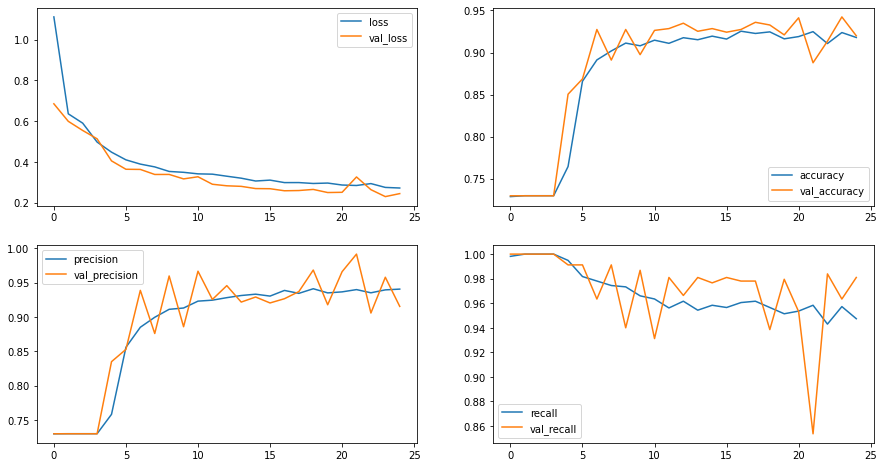

In [93]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn9_history.epoch, cnn9_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn9_history.epoch, cnn9_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn9_history.epoch, cnn9_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn9_history.epoch, cnn9_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn9_history.epoch, cnn9_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn9_history.epoch, cnn9_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn9_history.epoch, cnn9_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn9_history.epoch, cnn9_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');

In [94]:
y_pred = (cnn9_model.predict(val_data) > 0.5).astype("int32")
cm = confusion_matrix(y_true= val_labels, y_pred=y_pred)  

30/30 [==============================] - 7s 222ms/step


Confusion matrix, without normalization
[[191  62]
 [ 13 670]]


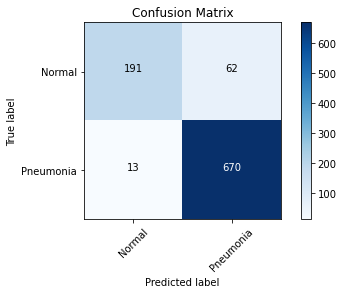

In [95]:
cm_labels = ['Normal','Pneumonia']
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix');

In [96]:
results = cnn9_model.evaluate(validation_generator)

1/1 [==============================] - 25s 25s/step - loss: 0.2440 - accuracy: 0.9199 - precision: 0.9153 - recall: 0.9810


In [97]:
print(f"Model loss:  {results[0]}")
print(f"Model accuracy: {results[1]}")
print(f"Model precision: {results[2]}")
print(f"Model recall: {results[3]}")

Model loss:  0.24401149153709412
Model accuracy: 0.9198718070983887
Model precision: 0.9153005480766296
Model recall: 0.980966329574585


### CNN Model 10

In [98]:
cnn10_model = models.Sequential()
cnn10_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.025)))
cnn10_model.add(layers.MaxPooling2D((3, 3)))
cnn10_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
cnn10_model.add(layers.MaxPooling2D((3, 3)))
cnn10_model.add(layers.Conv2D(16, (2, 2), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
cnn10_model.add(layers.MaxPooling2D((3, 3)))
cnn10_model.add(layers.Flatten())
cnn10_model.add(layers.Dense(16, activation='relu'))
cnn10_model.add(layers.Dropout(0.3))
cnn10_model.add(layers.Dense(1, activation='sigmoid'))

cnn10_model.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=1e-8,
                           patience=10,
                           verbose=1,
                           mode='max')

cnn10_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 147, 147, 64)      1088      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 49, 49, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 47, 47, 32)        18464     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 14, 14, 16)        2064      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 4, 4, 16)       

In [99]:
cnn10_history = cnn10_model.fit(train_data,
               train_labels,
               batch_size=32,
               epochs=50,
               validation_data=(val_data, val_labels),
               callbacks=[early_stop])

Epoch 1/50
118/118 [==============================] - 100s 822ms/step - loss: 1.0975 - accuracy: 0.7215 - precision: 0.7304 - recall: 0.9803 - val_loss: 0.6819 - val_accuracy: 0.7297 - val_precision: 0.7297 - val_recall: 1.0000
Epoch 2/50
118/118 [==============================] - 94s 801ms/step - loss: 0.6354 - accuracy: 0.7295 - precision: 0.7301 - recall: 0.9985 - val_loss: 0.6069 - val_accuracy: 0.7297 - val_precision: 0.7297 - val_recall: 1.0000
Epoch 3/50
118/118 [==============================] - 94s 796ms/step - loss: 0.5789 - accuracy: 0.7343 - precision: 0.7377 - recall: 0.9868 - val_loss: 0.4776 - val_accuracy: 0.7457 - val_precision: 0.7416 - val_recall: 1.0000
Epoch 4/50
118/118 [==============================] - 93s 791ms/step - loss: 0.4440 - accuracy: 0.8216 - precision: 0.8290 - recall: 0.9518 - val_loss: 0.3099 - val_accuracy: 0.9167 - val_precision: 0.9267 - val_recall: 0.9619
Epoch 5/50
118/118 [==============================] - 94s 793ms/step - loss: 0.3884 - accur

In [100]:
cnn10_model.save('models/cnn10')

INFO:tensorflow:Assets written to: models/cnn10/assets


INFO:tensorflow:Assets written to: models/cnn10/assets


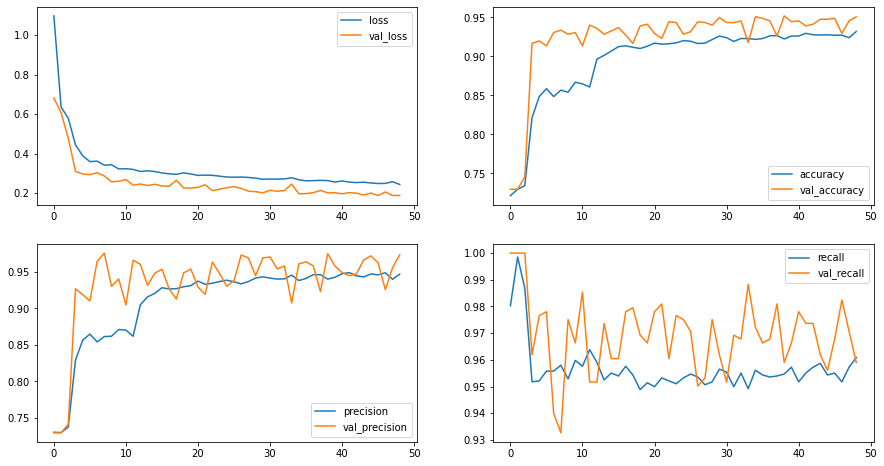

In [101]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn10_history.epoch, cnn10_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn10_history.epoch, cnn10_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn10_history.epoch, cnn10_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn10_history.epoch, cnn10_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn10_history.epoch, cnn10_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn10_history.epoch, cnn10_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn10_history.epoch, cnn10_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn10_history.epoch, cnn10_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');


In [102]:
y_pred = (cnn10_model.predict(val_data) > 0.5).astype("int32")
cm = confusion_matrix(y_true= val_labels, y_pred=y_pred) 
 

30/30 [==============================] - 7s 224ms/step


Confusion matrix, without normalization
[[235  18]
 [ 28 655]]


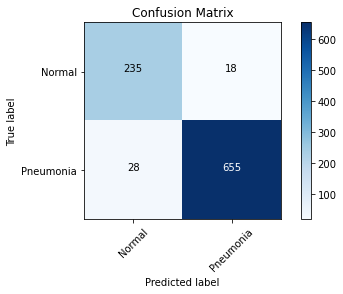

In [103]:
cm_labels = ['Normal','Pneumonia']
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix');

In [104]:
results = cnn10_model.evaluate(validation_generator)

1/1 [==============================] - 28s 28s/step - loss: 0.1879 - accuracy: 0.9509 - precision: 0.9733 - recall: 0.9590


In [105]:
print(f"Model loss:  {results[0]}")
print(f"Model accuracy: {results[1]}")
print(f"Model precision: {results[2]}")
print(f"Model recall: {results[3]}")

Model loss:  0.18793272972106934
Model accuracy: 0.9508547186851501
Model precision: 0.9732540845870972
Model recall: 0.9590044021606445


### CNN Model 11

In [106]:
cnn11_model = models.Sequential()
cnn11_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.025)))
cnn11_model.add(layers.MaxPooling2D((3, 3)))
cnn11_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
cnn11_model.add(layers.MaxPooling2D((3, 3)))
cnn11_model.add(layers.Flatten())
cnn11_model.add(layers.Dense(16, activation='relu'))
cnn11_model.add(layers.Dropout(0.3))
cnn11_model.add(layers.Dense(1, activation='sigmoid'))

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           patience=10,
                           verbose=1,
                           mode='min')

cnn11_model.compile(optimizer="adam",
                           loss='binary_crossentropy',
                           metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])

cnn11_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 147, 147, 64)      1088      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 49, 49, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 47, 47, 32)        18464     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 7200)              0         
                                                                 
 dense_22 (Dense)            (None, 16)              

In [107]:
cnn11_history = cnn11_model.fit(train_data,
               train_labels,
               batch_size=32,
               epochs=50,
               validation_data=(val_data, val_labels),
               callbacks=[early_stop])

Epoch 1/50
118/118 [==============================] - 97s 807ms/step - loss: 0.8289 - accuracy: 0.7255 - precision: 0.7305 - recall: 0.9887 - val_loss: 0.4756 - val_accuracy: 0.7297 - val_precision: 0.7297 - val_recall: 1.0000
Epoch 2/50
118/118 [==============================] - 95s 806ms/step - loss: 0.4286 - accuracy: 0.7743 - precision: 0.7708 - recall: 0.9832 - val_loss: 0.3579 - val_accuracy: 0.8718 - val_precision: 0.8541 - val_recall: 0.9941
Epoch 3/50
118/118 [==============================] - 94s 800ms/step - loss: 0.3820 - accuracy: 0.8674 - precision: 0.8766 - recall: 0.9525 - val_loss: 0.3223 - val_accuracy: 0.9060 - val_precision: 0.9115 - val_recall: 0.9649
Epoch 4/50
118/118 [==============================] - 94s 799ms/step - loss: 0.3581 - accuracy: 0.8845 - precision: 0.9070 - recall: 0.9379 - val_loss: 0.3068 - val_accuracy: 0.8910 - val_precision: 0.8817 - val_recall: 0.9824
Epoch 5/50
118/118 [==============================] - 94s 799ms/step - loss: 0.3424 - accura

In [108]:
cnn11_model.save('models/cnn11')

INFO:tensorflow:Assets written to: models/cnn11/assets


INFO:tensorflow:Assets written to: models/cnn11/assets


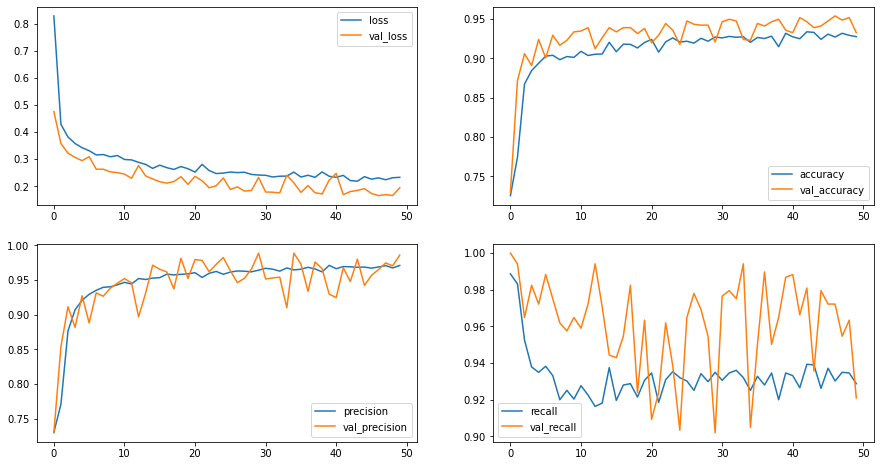

In [109]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn11_history.epoch, cnn11_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn11_history.epoch, cnn11_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn11_history.epoch, cnn11_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn11_history.epoch, cnn11_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn11_history.epoch, cnn11_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn11_history.epoch, cnn11_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn11_history.epoch, cnn11_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn11_history.epoch, cnn11_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');


In [110]:
y_pred = (cnn11_model.predict(val_data) > 0.5).astype("int32")
cm = confusion_matrix(y_true= val_labels, y_pred=y_pred) 


30/30 [==============================] - 7s 216ms/step


Confusion matrix, without normalization
[[244   9]
 [ 54 629]]


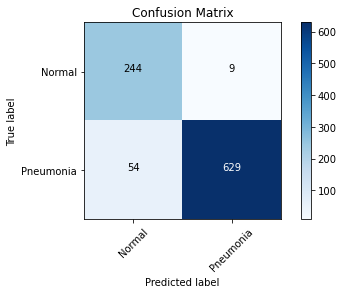

In [111]:
cm_labels = ['Normal','Pneumonia']
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix');

In [112]:
results = cnn11_model.evaluate(validation_generator)

1/1 [==============================] - 23s 23s/step - loss: 0.1946 - accuracy: 0.9327 - precision: 0.9859 - recall: 0.9209


In [113]:
print(f"Model loss:  {results[0]}")
print(f"Model accuracy: {results[1]}")
print(f"Model precision: {results[2]}")
print(f"Model recall: {results[3]}")

Model loss:  0.19461295008659363
Model accuracy: 0.932692289352417
Model precision: 0.9858934283256531
Model recall: 0.9209370613098145


### CNN Model 12

In [114]:
cnn12_model = models.Sequential()
cnn12_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.025)))
cnn12_model.add(layers.MaxPooling2D((3, 3)))
cnn12_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
cnn12_model.add(layers.MaxPooling2D((3, 3)))
cnn12_model.add(layers.Flatten())
cnn12_model.add(layers.Dense(16, activation='relu'))
cnn12_model.add(layers.Dropout(0.3))
cnn12_model.add(layers.Dense(1, activation='sigmoid'))

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           patience=10,
                           verbose=1,
                           mode='min')

cnn12_model.compile(optimizer="adam",
                           loss='binary_crossentropy',
                           metrics=['accuracy', metrics.Precision(name='precision', thresholds=0.3), metrics.Recall(name='recall', thresholds=0.3)]) 

cnn12_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 147, 147, 64)      1088      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 49, 49, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 47, 47, 32)        18464     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 7200)              0         
                                                                 
 dense_24 (Dense)            (None, 16)              

In [115]:
cnn12_history = cnn12_model.fit(train_data,
               train_labels,
               batch_size=32,
               epochs=30,
               validation_data=(val_data, val_labels),
               callbacks=[early_stop])

Epoch 1/30
118/118 [==============================] - 99s 813ms/step - loss: 0.8505 - accuracy: 0.7226 - precision: 0.7298 - recall: 1.0000 - val_loss: 0.5037 - val_accuracy: 0.7297 - val_precision: 0.7297 - val_recall: 1.0000
Epoch 2/30
118/118 [==============================] - 95s 803ms/step - loss: 0.4392 - accuracy: 0.7871 - precision: 0.7298 - recall: 1.0000 - val_loss: 0.3797 - val_accuracy: 0.8718 - val_precision: 0.7297 - val_recall: 1.0000
Epoch 3/30
118/118 [==============================] - 95s 808ms/step - loss: 0.3865 - accuracy: 0.8709 - precision: 0.7298 - recall: 1.0000 - val_loss: 0.3833 - val_accuracy: 0.8451 - val_precision: 0.7297 - val_recall: 1.0000
Epoch 4/30
118/118 [==============================] - 97s 819ms/step - loss: 0.3673 - accuracy: 0.8781 - precision: 0.7298 - recall: 1.0000 - val_loss: 0.3108 - val_accuracy: 0.9156 - val_precision: 0.7297 - val_recall: 1.0000
Epoch 5/30
118/118 [==============================] - 98s 834ms/step - loss: 0.3299 - accura

In [116]:
cnn12_model.save('models/cnn12')

INFO:tensorflow:Assets written to: models/cnn12/assets


INFO:tensorflow:Assets written to: models/cnn12/assets


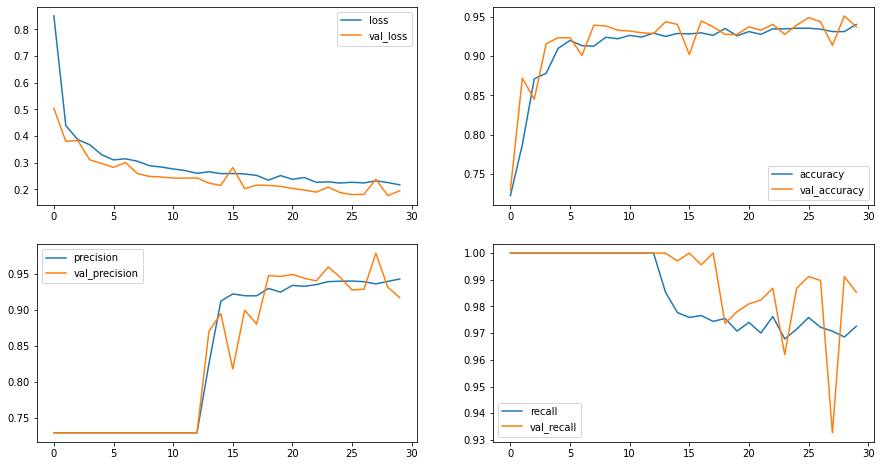

In [117]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn12_history.epoch, cnn12_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn12_history.epoch, cnn12_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn12_history.epoch, cnn12_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn12_history.epoch, cnn12_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn12_history.epoch, cnn12_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn12_history.epoch, cnn12_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn12_history.epoch, cnn12_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn12_history.epoch, cnn12_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');


In [118]:
y_pred = (cnn12_model.predict(val_data) > 0.5).astype("int32")
cm = confusion_matrix(y_true= val_labels, y_pred=y_pred) 


30/30 [==============================] - 7s 229ms/step


Confusion matrix, without normalization
[[212  41]
 [ 18 665]]


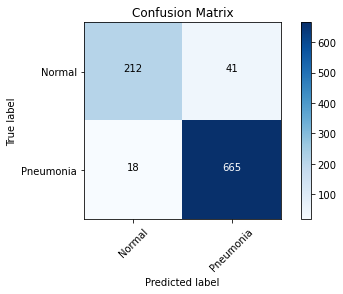

In [119]:
cm_labels = ['Normal','Pneumonia']
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix');

In [120]:
results = cnn12_model.evaluate(validation_generator)

1/1 [==============================] - 26s 26s/step - loss: 0.1944 - accuracy: 0.9370 - precision: 0.9169 - recall: 0.9854


In [121]:
print(f"Model loss:  {results[0]}")
print(f"Model accuracy: {results[1]}")
print(f"Model precision: {results[2]}")
print(f"Model recall: {results[3]}")

Model loss:  0.19443213939666748
Model accuracy: 0.936965823173523
Model precision: 0.916893720626831
Model recall: 0.985358715057373


In [131]:
y_pred = (cnn7_model.predict(test_data) > 0.5).astype("int32")
cm = confusion_matrix(y_true= test_labels, y_pred=y_pred)  

35/35 [==============================] - 11s 327ms/step


Confusion matrix, without normalization
[[291  26]
 [ 21 769]]


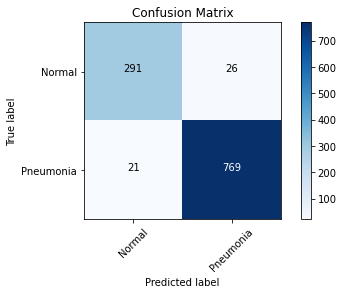

In [136]:
cm_labels = ['Normal','Pneumonia']
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix');
plt.savefig('confusion_matrix_test.png', dpi=400)

In [135]:
plt.savefig('confusion_matrix_test.png', dpi=400)

<Figure size 432x288 with 0 Axes>

In [127]:
results = cnn7_model.evaluate(test_generator)

1/1 [==============================] - 38s 38s/step - loss: 0.1993 - accuracy: 0.9575 - precision: 0.9673 - recall: 0.9734


In [128]:
print(f"Model loss:  {results[0]}")
print(f"Model accuracy: {results[1]}")
print(f"Model precision: {results[2]}")
print(f"Model recall: {results[3]}")

Model loss:  0.19930499792099
Model accuracy: 0.957542896270752
Model precision: 0.9672955870628357
Model recall: 0.9734176993370056


In [129]:
test_data

array([[[[0.01568628],
         [0.9921569 ],
         [0.04705883],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.01176471],
         [0.9921569 ],
         [0.03529412],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.01176471],
         [0.98823535],
         [0.01568628],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        ...,

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]],


       [[[0.20392159],
         [0.19215688],
         [0.17

In [130]:
val_data

array([[[[0.58431375],
         [0.4666667 ],
         [0.4901961 ],
         ...,
         [0.1764706 ],
         [0.21176472],
         [0.47058827]],

        [[0.54901963],
         [0.5294118 ],
         [0.4666667 ],
         ...,
         [0.18431373],
         [0.28627452],
         [0.4156863 ]],

        [[0.5686275 ],
         [0.5647059 ],
         [0.50980395],
         ...,
         [0.19215688],
         [0.27450982],
         [0.20000002]],

        ...,

        [[0.06666667],
         [0.02745098],
         [0.00392157],
         ...,
         [0.05490196],
         [0.05490196],
         [0.0509804 ]],

        [[0.01176471],
         [0.02745098],
         [0.00392157],
         ...,
         [0.05490196],
         [0.05490196],
         [0.        ]],

        [[0.03529412],
         [0.02745098],
         [0.00392157],
         ...,
         [0.05490196],
         [0.05490196],
         [0.05490196]]],


       [[[0.34901962],
         [0.34117648],
         [0.34